<a href="https://colab.research.google.com/github/manikBS/omscs-capstone/blob/master/yash_tft_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=516b3fddab95276475f64787bada630144f5b3bf4c9cee5fb23fccc9acca5a7e
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
import os
import ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import pytorch_lightning as pl

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE


# TODO: Fill in the Google Drive path where you uploaded assignment1
# Example: If you create a Fall2023 folder and put all the files under A1 folder, then 'Fall2023/A1'
GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'capstone_project'
user = 'ydosi3'
if user == 'ydosi3':
  GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive',
                                   'MyDrive/Colab Notebooks', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
else:
  GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive',
                                   GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

import sys
sys.path.append(GOOGLE_DRIVE_PATH)

os.environ['GOOGLE_DRIVE_PATH'] = GOOGLE_DRIVE_PATH

os.environ['GOOGLE_DRIVE_PATH']

['data', 'utils', 'src', 'models_results', 'notebooks', 'data_processing.ipynb']


'/content/drive/MyDrive/Colab Notebooks/capstone_project'

In [ ]:
# hyperparams
RSI_WINDOW = 60
MACD_SLOW_WINDOW = 120
MACD_FAST_WINDOW = 60
MACD_SIGNAL_WINDOW = 120
STOCH_WINDOW = 90
TOTAL_DATA_LEN = 10000
TRAINING_DATA_RATIO = 0.8
VALIDATION_DATA_RATIO = 0.1
TESTING_DATA_RATIO = 0.1

data_base = f"{os.environ['GOOGLE_DRIVE_PATH']}/data"
data = pd.read_csv(f"{data_base}/NIFTY 50_minute_data.csv", parse_dates=['date'])
data['cal_date'] = pd.to_datetime(data['date'].dt.date)

daily_data = pd.read_csv(f"{data_base}/NIFTY 50_daily_data.csv", parse_dates=['date'])
daily_data['date'] = pd.to_datetime(daily_data['date'])
# Calculate the percentage gap between the current day's open and the previous day's close
daily_data['previous_close'] = daily_data['close'].shift(1)
daily_data['gap_percentage'] = ((daily_data['open'] - daily_data['previous_close']) / daily_data['previous_close']) * 100

gap_threshold = 0.7
# Categorize the gap as 'gap_up', 'gap_down', or 'no_gap'
daily_data['gap_type'] = np.where(daily_data['gap_percentage'] > gap_threshold, 'gap_up',
                                 np.where(daily_data['gap_percentage'] < -gap_threshold, 'gap_down', 'no_gap'))

vix_min = pd.read_csv(f"{data_base}/INDIA VIX_minute.csv", parse_dates=['date'])
# Rename columns in the 'data' DataFrame
vix_min = vix_min.rename(columns={
    'date': 'vix_date',
    'open': 'vix_open',
    'high': 'vix_high',
    'low': 'vix_low',
    'close': 'vix_close',
    'volume': 'vix_volume'
})
vix_min.drop(columns=['vix_volume'], inplace=True)

In [ ]:
# Rename columns in the 'data' DataFrame
data = data.rename(columns={
    'date': 'min_date',
    'open': 'min_open',
    'high': 'min_high',
    'low': 'min_low',
    'close': 'min_close',
    'volume': 'min_volume'
})
data['hour'] = data['min_date'].dt.hour
data['hour'] = data['hour'].astype(str)

data["hour_start"] = data["min_date"].dt.floor("h")
# Calculate the return from the start of the hour
data = data.merge(data.groupby("hour_start")["min_close"].first(), on="hour_start", suffixes=("", "_start"))
data["hourly_return"] = (data["min_close"] - data["min_close_start"]) / data["min_close_start"]

In [ ]:
data.head()

,min_date,min_open,min_high,min_low,min_close,min_volume,cal_date,hour,hour_start,min_close_start,hourly_return
0,2015-01-09 09:15:00,8285.45,8295.90,8285.45,8292.10,0,2015-01-09,9,2015-01-09 09:00:00,8292.1,0.000000
1,2015-01-09 09:16:00,8292.60,8293.60,8287.20,8288.15,0,2015-01-09,9,2015-01-09 09:00:00,8292.1,-0.000476
2,2015-01-09 09:17:00,8287.40,8293.90,8287.40,8293.90,0,2015-01-09,9,2015-01-09 09:00:00,8292.1,0.000217
3,2015-01-09 09:18:00,8294.25,8300.65,8293.90,8300.65,0,2015-01-09,9,2015-01-09 09:00:00,8292.1,0.001031
4,2015-01-09 09:19:00,8300.60,8301.30,8298.75,8301.20,0,2015-01-09,9,2015-01-09 09:00:00,8292.1,0.001097


In [ ]:
merged_data = pd.merge(data, daily_data, left_on='cal_date', right_on='date', how='left')
merged_data = pd.merge(merged_data, vix_min, left_on='min_date', right_on='vix_date', how='left')
merged_data = merged_data.drop(['volume', 'min_volume', 'previous_close', 'open', 'high', 'low',
                                'close', 'date', 'cal_date', 'vix_date', 'hour_start'], axis=1)
merged_data = merged_data.rename(columns={
    'min_open': 'open',
    'min_high': 'high',
    'min_low': 'low',
    'min_close': 'close',
})

In [ ]:
merged_data.head()

,min_date,open,high,low,close,hour,min_close_start,hourly_return,gap_percentage,gap_type,vix_open,vix_high,vix_low,vix_close
0,2015-01-09 09:15:00,8285.45,8295.90,8285.45,8292.10,9,8292.1,0.000000,0.617516,no_gap,16.47,16.47,14.46,15.39
1,2015-01-09 09:16:00,8292.60,8293.60,8287.20,8288.15,9,8292.1,-0.000476,0.617516,no_gap,15.39,15.47,15.33,15.45
2,2015-01-09 09:17:00,8287.40,8293.90,8287.40,8293.90,9,8292.1,0.000217,0.617516,no_gap,15.45,15.51,15.41,15.46
3,2015-01-09 09:18:00,8294.25,8300.65,8293.90,8300.65,9,8292.1,0.001031,0.617516,no_gap,15.46,15.50,15.33,15.40
4,2015-01-09 09:19:00,8300.60,8301.30,8298.75,8301.20,9,8292.1,0.001097,0.617516,no_gap,15.39,15.40,15.29,15.35


In [ ]:
"""
Buy & Hold - I buy 1 unit on 1st Apr 2022 & sell on 31st March 2025
Benchmark 2 - Optional
---
t1 -> 60 min -> 15 min forecast -> CNN -> double bottom ->
---
Simulation for k days with start_date and starting capital
"""

In [ ]:
"""
1. Transfers just forecasts close prices.

Forecasting Indicators:
  RSI
  EMA(60 window)
  BB
  Z-Score
  VIX
  gap_up_down
  hourly_return
Classification Indicators:
  RSI - Overbought/Oversold - 15 timesteps
  EMA - Baseline for price movement - 15 timesteps
  Z-Score - Volatility - 15 timesteps
Report Points:
 - HLD of the overall system
 - Success criteria and result evaluation
  - Over all project (beating the market)
  - Individual models & Experiments
    - CNNs
      - Indicator selection
    - Transformers
      - Indicator selection
      - What did we do to improve model accuracy?
"""

In [ ]:
data1 = merged_data[['open', 'high', 'low', 'close', 'gap_percentage', 'gap_type',
                     'vix_open', 'vix_high', 'vix_low', 'vix_close', 'hour', 'min_close_start', 'hourly_return']]

# Calculate RSI
data1['RSI'] = ta.momentum.RSIIndicator(data1['close'], window=RSI_WINDOW).rsi()

# Calculate MACD
macd = ta.trend.MACD(data1['close'], window_slow=MACD_SLOW_WINDOW,
                     window_fast=MACD_FAST_WINDOW, window_sign=MACD_SIGNAL_WINDOW)
data1['MACD'] = macd.macd()
data1['MACD_signal'] = macd.macd_signal()
data1['MACD_diff'] = macd.macd_diff()

# Calculate Stochastic Oscillator
stoch = ta.momentum.StochasticOscillator(data1['high'], data1['low'], data1['close'], window=STOCH_WINDOW)
data1['stoch'] = stoch.stoch()
data1['stoch_signal'] = stoch.stoch_signal()
data1["stock"] = "NIFTY_IDX"

data1.dropna(axis=0, how='any', inplace=True)

# add index column
data1["time_idx"] = data1.index

df = data1[:10000]

train_df = df[:int(TOTAL_DATA_LEN*TRAINING_DATA_RATIO)]
val_df = df[int(TOTAL_DATA_LEN*TRAINING_DATA_RATIO):
            int(TOTAL_DATA_LEN*(TRAINING_DATA_RATIO+VALIDATION_DATA_RATIO))]
test_df = df[int(TOTAL_DATA_LEN*(TRAINING_DATA_RATIO+VALIDATION_DATA_RATIO)):]

In [ ]:
# TODO:
# These two will be known during the forecasting.
#   Add hourly metrics - they serve has more recent market sentiment (evoling during the day)
# Can we get all features and do a PCA over that?
# How can we use grouping? Does hourly grouping make sense? How is grouping useful in TFT?
# Will return till hour from open be a useful feature?
# Scaling

# Findings:
# min_close_start & hourly_return did not help - maybe it helps with the return_on_day column?

In [ ]:
train_df.shape[0]

8000

In [ ]:
train_df.columns

Index(['open', 'high', 'low', 'close', 'gap_percentage', 'gap_type',
       'vix_open', 'vix_high', 'vix_low', 'vix_close', 'hour',
       'min_close_start', 'hourly_return', 'RSI', 'MACD', 'MACD_signal',
       'MACD_diff', 'stoch', 'stoch_signal', 'stock', 'time_idx'],
      dtype='object')

In [ ]:
# ---------------------------
# 2. Setup forecasting parameters
# ---------------------------
max_encoder_length =    60    # lookback window (30 minutes)
max_prediction_length = 15 # forecast horizon (15 minutes)

# Use the last forecast horizon period for validation
# training_cutoff = 9000

# ---------------------------
# 3. Create a TimeSeriesDataSet
# ---------------------------
# Here, we set the "target" as the 'close' price.
# "time_idx" is provided as a known variable, while the rest of the OHLC and indicator features are only used in history.
training_data = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target="close",
    group_ids=["stock"],
    # Fixed history and forecast lengths:
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    # In our setting we assume that only the time index is known
    # (you could add additional known features if available)
    time_varying_known_reals=["time_idx", "gap_percentage"],
    # Historical features (OHLC and the extra indicators) are unknown in the future and help inform past behavior
    time_varying_unknown_reals=['open', 'high', 'low', 'close', 'RSI', 'MACD', 'MACD_signal',
                                'MACD_diff', 'stoch', 'stoch_signal', 'vix_open',
                                'vix_high', 'vix_low', 'vix_close'],
    time_varying_known_categoricals=['gap_type', 'hour'],
    # Normalize the target by group. Softplus ensures non-negative predictions.
    target_normalizer=GroupNormalizer(
        groups=["stock"], transformation="softplus"
    ),
)

# Create dataloaders for training and validation:
batch_size = 64
train_dataloader = training_data.to_dataloader(train=True, batch_size=batch_size, num_workers=0)

# Build the validation dataset from the same dataset (ensuring consistent preprocessing)
validation_data = TimeSeriesDataSet.from_dataset(
    training_data, val_df, stop_randomization=True, predict=True,
    min_encoder_length=max_encoder_length, max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length, max_prediction_length=max_prediction_length
)

valid_dataloader = validation_data.to_dataloader(batch_size=batch_size, num_workers=0, train=False)

# ---------------------------
# 4. Build and train the TFT model
# ---------------------------
# We use TemporalFusionTransformer.from_dataset to auto-configure many model parameters.
tft = TemporalFusionTransformer.from_dataset(
    training_data,
    learning_rate=0.03,
    hidden_size=32,             # size of internal layers (tune based on your data)
    attention_head_size=2,      # number of attention heads
    dropout=0.1,
    hidden_continuous_size=16,   # dimensionality for continuous variable processing
    output_size=1,              # default output size (used for quantile forecasts)
    loss=SMAPE(),               # Symmetric Mean Absolute Percentage Error
    log_interval=10,
    reduce_on_plateau_patience=4,
    causal_attention=True,
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Configure a PyTorch Lightning Trainer:
trainer = pl.Trainer(
    max_epochs=5,
    gradient_clip_val=0.1,
)

# Wrap the TFT model with the PyTorch Lightning module
class TFTLightningModule(pl.LightningModule):
    def __init__(self, tft):
        super().__init__()
        self.tft = tft
        self.train_losses_per_epoch = []
        self.validation_losses_per_epoch = []
        # self.save_hyperparameters(ignore=["model", "loss", "logging_metrics"])

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.tft(x)
        loss = self.tft.loss(y_hat["prediction"][:, :, 0], y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True,
                 batch_size=x['encoder_target'].shape[0])
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.tft(x)
        loss = self.tft.loss(y_hat["prediction"][:, :, 0], y)
        self.log("val_loss", loss, prog_bar=True, batch_size=x['encoder_target'].shape[0])
        return loss

    def test_step(self, batch, batch_idx):
        # Perform a single test step
        x, y = batch
        out = self.tft(x)
        y_pred = out[0]  # The model output is a tuple, 'y_pred' is the first element
        loss = self.tft.loss(y_pred, y)
        self.log("test_loss", loss, prog_bar=True, batch_size=x['encoder_target'].shape[0])
        return loss

    def on_train_epoch_end(self):
        self.train_losses_per_epoch.append(self.trainer.callback_metrics['train_loss'].item())
        self.validation_losses_per_epoch.append(self.trainer.callback_metrics['val_loss'].item())

    def configure_optimizers(self):
        return self.tft.configure_optimizers()


# Create an instance of the Lightning module, wrapping the TFT model
tft_lightning_module = TFTLightningModule(tft)

# Train the model:
trainer.fit(
    tft_lightning_module,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
tft_lightning_module.train_losses_per_epoch

[0.0048830341547727585,
 0.0018156967125833035,
 0.0015303179388865829,
 0.0013606683351099491,
 0.0012521360768005252]

In [ ]:
tft_lightning_module.train_losses_per_epoch

[0.004659649915993214,
 0.0024263232480734587,
 0.0020773897413164377,
 0.0017578563420102,
 0.0017058432567864656]

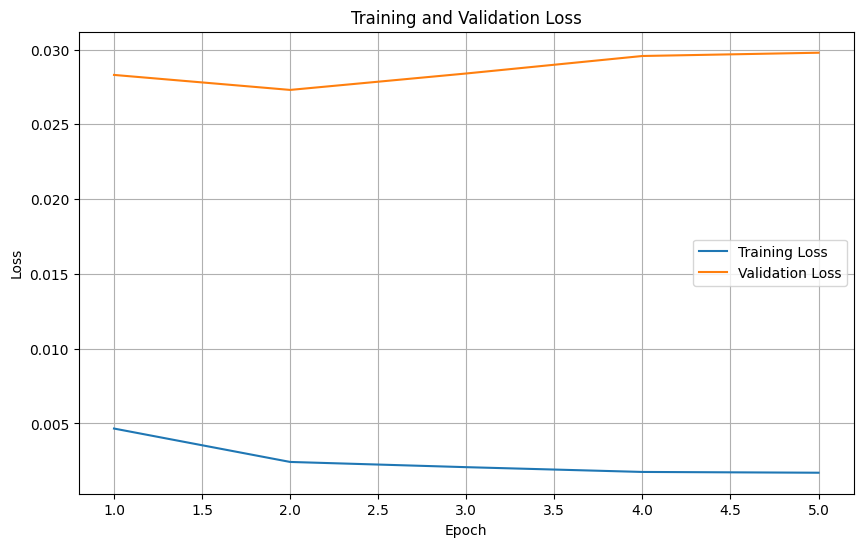

In [ ]:
train_losses = tft_lightning_module.train_losses_per_epoch
val_losses = tft_lightning_module.validation_losses_per_epoch

# Create epoch array
epochs = range(1, len(train_losses) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

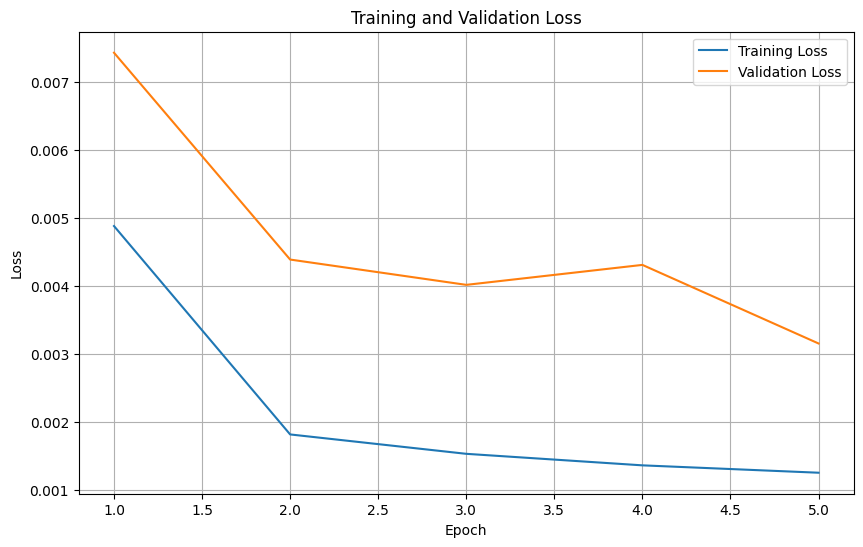

In [ ]:
train_losses = tft_lightning_module.train_losses_per_epoch
val_losses = tft_lightning_module.validation_losses_per_epoch

# Create epoch array
epochs = range(1, len(train_losses) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Assuming you have 'data1' containing your entire dataset

# Select 30 minutes of data for testing
test_df1 = data1[10001:10037]  # Select data from index 10001 to 10030 (30 minutes)

# print(test_df.shape)
# Create test dataset and data loader
test_data = TimeSeriesDataSet.from_dataset(
    training_data,
    test_df1,
    predict=True,
    stop_randomization=True,
    # min_encoder_length=24,
    # max_encoder_length=24,
    # min_prediction_length=6,
    # max_prediction_length=6
)

test_dataloader = test_data.to_dataloader(batch_size=1, num_workers=0, train=False)

# Get predictions
predictions = tft.predict(test_dataloader)

# predictions will contain the 6-minute forecast for the 30-minute input data

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
predictions

tensor([[8640.5137, 8627.7461, 8626.4219, 8626.7812, 8626.8750, 8626.8447]])

In [ ]:
predictions

tensor([[8655.3047, 8678.2568, 8683.0674, 8683.0742, 8682.9629, 8682.9229]])

In [ ]:
predictions.prediction

tensor([[[8655.3047],
         [8678.2568],
         [8683.0674],
         [8683.0742],
         [8682.9629],
         [8682.9229]]])

In [ ]:
r.x.keys()

dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])

In [ ]:
tft.plot_prediction(r.x, r.output, r.x["decoder_time_idx"])

IndexError: index 10064 is out of bounds for dimension 0 with size 1